<a href="https://colab.research.google.com/github/aliajder/KADEP/blob/main/Actuals_LSTM_Data_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
#mpl.rcParams['figure.figsize'] = (17, 5)
#mpl.rcParams['axes.grid'] = False
#sns.set_style("whitegrid")
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf
import csv

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Actuals_Data_Set/"Actuals.xlsx"

[Errno 20] Not a directory: '/content/drive/MyDrive/Actuals_Data_Set/Actuals.xlsx'
/content


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Actuals_Data_Set/Actuals.xlsx")

In [ ]:
df.head()

,Time,Load (kW),Pressure_kpa,Cloud Cover (%),Humidity (%),Temperature (C),Wind Direction (deg),Wind Speed (kmh)
0,2017-03-18 00:00:00,1.031472e+06,1012.48000,2.125,79.333333,16.764386,285.25,6.25375
1,2017-03-18 01:00:00,1.007206e+06,1011.61875,0.000,82.166667,15.729386,285.00,9.20500
2,2017-03-18 02:00:00,9.861084e+05,1010.72000,2.125,81.666667,15.816886,316.00,11.28375
3,2017-03-18 03:00:00,9.707610e+05,1011.37625,17.125,82.250000,15.919386,327.00,7.16875
4,2017-03-18 04:00:00,9.622584e+05,1011.50000,18.625,82.333333,15.769386,282.25,0.78000


In [ ]:
columns_to_drop = ['Time', 'Pressure_kpa', 'Cloud Cover (%)', 'Humidity (%)', 'Temperature (C)', 'Wind Direction (deg)', 'Wind Speed (kmh)']
columns_to_drop = [column for column in columns_to_drop if column in df.columns]
df = df.drop(columns=columns_to_drop)

# Save the updated DataFrame to a new Excel file
df.to_excel('updated_actuals.xlsx', index=False)

In [ ]:
df.head()

,Load (kW),Temperature (C)
0,1.031472e+06,16.764386
1,1.007206e+06,15.729386
2,9.861084e+05,15.816886
3,9.707610e+05,15.919386
4,9.622584e+05,15.769386


In [ ]:
count_nan = df.isnull().sum()
print('Number of NaN values present: ' + str(count_nan))


Number of NaN values present: Load (kW)           0
Temperature (C)     0
dtype: int64


In [ ]:
df_actuals = df

## LSTM Entegrasyon

In [ ]:
df_actuals.head()

,Load (kW),Temperature (C)
0,1.031472e+06,16.764386
1,1.007206e+06,15.729386
2,9.861084e+05,15.816886
3,9.707610e+05,15.919386
4,9.622584e+05,15.769386


In [ ]:
df

,Load (kW),Temperature (C)
0,1.031472e+06,16.764386
1,1.007206e+06,15.729386
2,9.861084e+05,15.816886
3,9.707610e+05,15.919386
4,9.622584e+05,15.769386
...,...,...
31907,1.242830e+06,21.299386
31908,1.239480e+06,22.419386
31909,1.234773e+06,22.971886
31910,1.240140e+06,24.314386


In [ ]:
class LSTM():
    def __init__(self, lookback, features, forecast):
        self.lookback = lookback
        self.features = features
        self.forecast = forecast


    def df(self, dataframe, lookback, features, forecast):
        df = dataframe.values
        # Create the X and y arrays
        self.X, self.y = [], []
        for i in range(self.lookback, len(df) - self.forecast):
            self.X.append(df[i-self.lookback:i])
            self.y.append(df[i:i+self.forecast, 0]) # USD feature

      # Reshape the X and y arrays
        self.X, self.y = np.array(self.X), np.array(self.y)
        self.X = np.reshape(self.X, (self.X.shape[0], self.X.shape[1], self.features)) # (batch_size, lookback, features)
        self.y = np.reshape(self.y, (self.y.shape[0], self.forecast)) # (batch_size, forecast)

        return self.X, self.y


In [ ]:
lstm = LSTM(lookback=1, features=2, forecast=1)

In [ ]:
X_all, y_all = lstm.df(dataframe = df, lookback = 1, features = 2, forecast = 1)

In [ ]:
X_all

array([[[1.03147163e+06, 1.67643862e+01]],

       [[1.00720558e+06, 1.57293862e+01]],

       [[9.86108401e+05, 1.58168862e+01]],

       ...,

       [[1.24282992e+06, 2.12993862e+01]],

       [[1.23947954e+06, 2.24193862e+01]],

       [[1.23477333e+06, 2.29718862e+01]]])

In [ ]:
y_all

array([[1007205.57843707],
       [ 986108.40071707],
       [ 970760.96691707],
       ...,
       [1239479.53613707],
       [1234773.33213707],
       [1240139.89813707]])

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3,random_state=123)

In [ ]:
print(y_all.max())
print(X_all.max())
print(y_all.min())
print(X_all.min())

print(np.mean(y_all))
print(np.mean(X_all))

1605192.04313707
1605192.04313707
845471.3581370697
-6.418113782548787
1152568.8914184242
576289.6758732145


In [ ]:
print("X_train shape : {}".format(X_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (22337, 1, 2)
y_train shape : (22337, 1)
X_test shape : (9573, 1, 2)
y_test shape : (9573, 1)


In [ ]:

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_model(l_rate, epoch, batchsize, x_train_data, y_train_data):

  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,mode='min', restore_best_weights=True)#ceed
  lstm_model = tf.keras.Sequential()
  #lstm_model.add(tf.keras.layers.LSTM(256,activation='relu',input_shape=(lstm.lookback, lstm.features),return_sequences=True))
  #lstm_model.add(tf.keras.layers.LSTM(128,activation='relu',input_shape=(lstm.lookback, lstm.features),return_sequences=True))
  #lstm_model.add(tf.keras.layers.LSTM(64,activation='relu',input_shape=(lstm.lookback, lstm.features),return_sequences=True))
  lstm_model.add(tf.keras.layers.LSTM(64,activation='relu'))
  lstm_model.add(tf.keras.layers.Dense(units=lstm.forecast))

  opt = tf.optimizers.Adam(learning_rate=l_rate)
  lstm_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=opt,
    metrics=[tf.metrics.MeanAbsoluteError()]
    )

  lstm_history = lstm_model.fit(x_train_data, y_train_data,
    epochs=epoch,
    batch_size = batchsize,
    verbose=1,
    validation_split = 0.2,
    shuffle=False,
    #callbacks = [early_stopping]
    )

  return lstm_history, lstm_model


In [ ]:
history, model = create_model(l_rate = 0.001, epoch = 300, batchsize = 64, x_train_data = X_train, y_train_data = y_train)

Epoch 1/300
280/280 [==============================] - 4s 5ms/step - loss: 877684850688.0000 - mean_absolute_error: 907422.5625 - val_loss: 282795802624.0000 - val_mean_absolute_error: 526590.9375
Epoch 2/300
280/280 [==============================] - 2s 6ms/step - loss: 67271180288.0000 - mean_absolute_error: 207452.4062 - val_loss: 2018453120.0000 - val_mean_absolute_error: 30736.1641
Epoch 3/300
280/280 [==============================] - 2s 6ms/step - loss: 1434416768.0000 - mean_absolute_error: 25996.4883 - val_loss: 1371427328.0000 - val_mean_absolute_error: 26309.5469
Epoch 4/300
280/280 [==============================] - 1s 5ms/step - loss: 1360068224.0000 - mean_absolute_error: 26093.1777 - val_loss: 1371832960.0000 - val_mean_absolute_error: 26368.1270
Epoch 5/300
280/280 [==============================] - 1s 3ms/step - loss: 1360185472.0000 - mean_absolute_error: 26100.0176 - val_loss: 1372036608.0000 - val_mean_absolute_error: 26393.9453
Epoch 6/300
280/280 [================

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss', linewidth=1,color='green')
    plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=1,color='purple')
    plt.title(title)
    plt.legend()

    plt.show()

<ipython-input-67-6b1627954cc9>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss', linewidth=1,color='green')
<ipython-input-67-6b1627954cc9>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=1,color='purple')


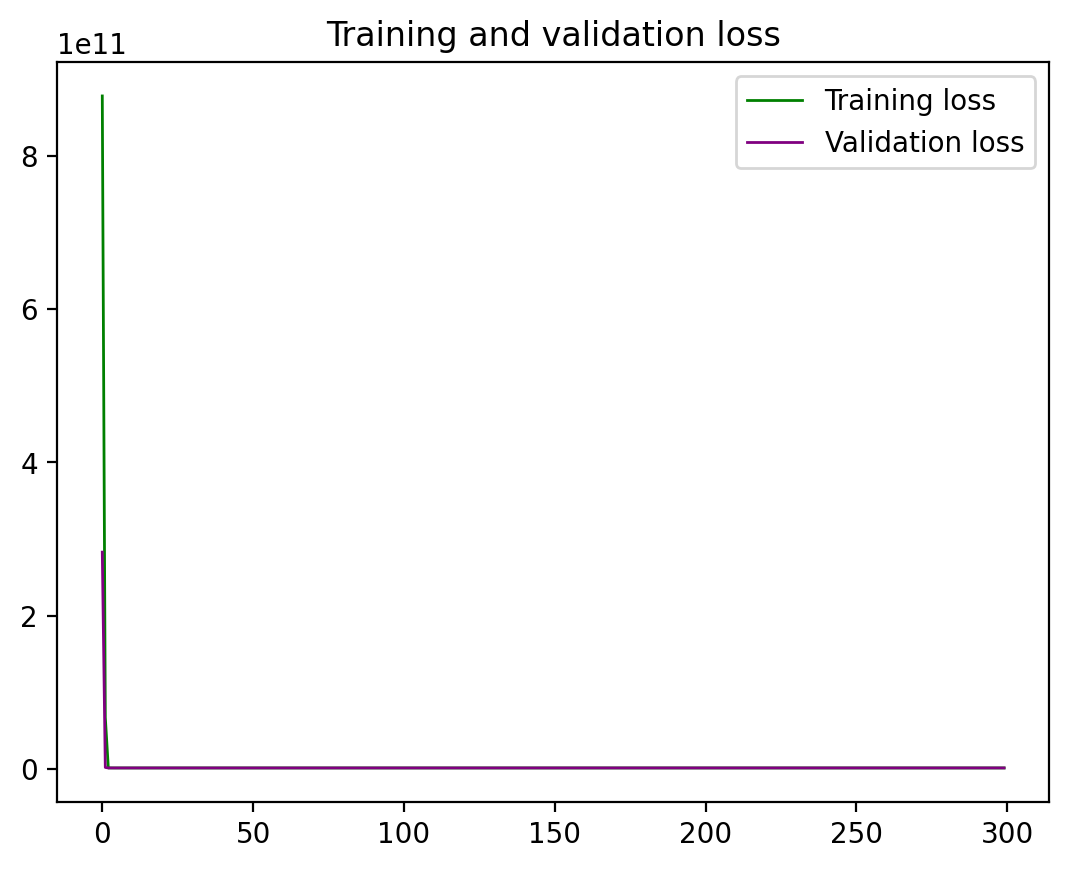

In [ ]:
plot_train_history(history,
                   'Training and validation loss')

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

300/300 [==============================] - 1s 2ms/step


In [ ]:
y_pred

array([[1232330.6],
       [1181916.9],
       [1186261.6],
       ...,
       [1274041.4],
       [1189438.5],
       [1395603.4]], dtype=float32)

In [ ]:
y_test

array([[1188841.80213707],
       [1170758.33813707],
       [1235966.66213707],
       ...,
       [1244572.69613707],
       [1173670.68613707],
       [1330318.45213707]])

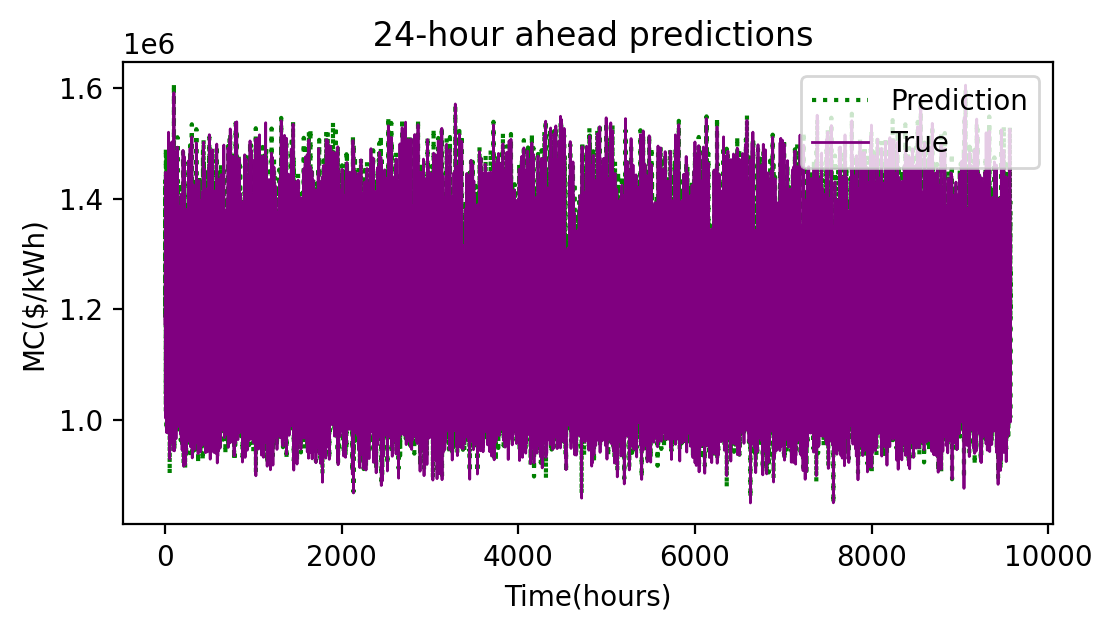

In [ ]:
plt.figure(figsize=(6,3))


plt.xlabel('Time(hours)')
plt.ylabel('MC($/kWh)')
plt.title(" 24-hour ahead predictions")

hour= 24
n_day = 365
plot_day = hour*n_day

plt.plot(y_pred[:,-1], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test[:, -1], label='True', linewidth=1,color='purple')
plt.legend()
plt.show()

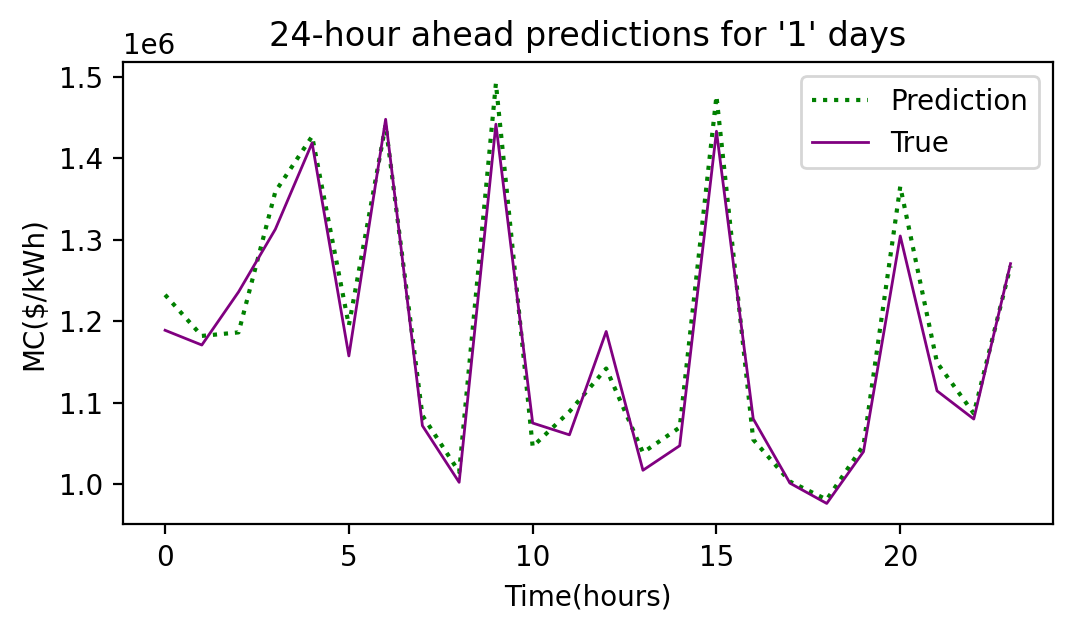

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Time(hours)')
plt.ylabel('MC($/kWh)')
plt.title("24-hour ahead predictions for '1' days")

# n_day kısmını değiştirerek yeni grafikler çizdirilebilir 5 günlük, 30 günlük vs.
hour= 24
n_day = 1
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1,color='purple')

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
errors = y_pred- y_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('Mean Absolute Error: {:.2f}'.format(mae))
print('Root Mean Square Error: {:.2f}'.format(rmse))
print('R2 Score: ', r2_score(y_test, y_pred))


Mean Absolute Error: 26734.83
Root Mean Square Error: 36261.53
R2 Score:  0.9413785107305104
